In [1]:
import pandas as pd
import numpy as np
import os
path_in = os.path.join("../Data")  # parent directory
np.random.seed(42)

import sys
sys.path.append(os.path.abspath(".."))  

from FinalToolModels.models import *
from FinalToolModels.simulate import *
from FinalToolModels.plot import *
from FinalToolModels.train import *
from FinalToolModels.split_dataset import *

%load_ext autoreload
%autoreload 2

# === Paths ===
###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join(path_in, "dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = split_dataset(cs1, testing_days=3, val_split=1.0)

# split_index = int(1 * len(cs1))
# end_index = int(len(cs1)) 
# train_cs1 = cs1.iloc[:split_index]
# val_cs1 = cs1.iloc[split_index:end_index]

###################### ======================== Case Study 2 ======================= ###########################

file_path = os.path.join(path_in, "dataset4.xlsx")
cs2 = pd.read_excel(file_path)
# Rename columns
rename_mapping = {
        'T_ext': 'OUTDOOR_TEMP',
        'heating_total [kW]': 'PHI_H',
        'GHI': 'PYRANOMETER',
        'T_int': 'INDOOR_TEMP'
    }
cs2 = cs2.rename(columns=rename_mapping)
cs2['PHI_H']=cs2['PHI_H']*1000
# Convert 't' to datetime and set as index

cs2['Time'] = pd.to_datetime(cs2['Time'])
cs2 = cs2.set_index('Time')
cs2 = cs2.resample("30min").mean()
cs2_surface_area = 2100  # m² 
cs2 = cs2.iloc[0:960]

train_cs2, val_cs2, test_cs2 = split_dataset(cs2, testing_days=3, val_split=1.0)

# split_index = int(1 * len(cs2))
# end_index = int(len(cs2)) 
# train_cs2 = cs2.iloc[:split_index]
# val_cs2 = cs2.iloc[split_index:end_index]

###################### ======================== Case Study 3 ======================= ###########################

file_path = os.path.join(path_in, "dataset5-cella.xlsx")
cs3 = pd.read_excel(file_path)
cs3["INDOOR_TEMP"] = cs3[["ra_zone_air_temp1_C", "ra_zone_air_temp2_C"]].mean(axis=1)
cs3['PHI_H']=cs3['ra_sup_air_flow_cmh']/3600*1.2*(cs3['ra_sup_air_temp_C']-cs3['INDOOR_TEMP'])*1005
# Rename columns
rename_mapping = {
        'oat_C': 'OUTDOOR_TEMP',
        'global_irradiance_Wm2': 'PYRANOMETER',
    }
cs3 = cs3.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs3['time'] = pd.to_datetime(cs3['time'])
cs3 = cs3.set_index('time')
cs3 = cs3.resample("30min").mean()
cs3=cs3[cs3.index>'2020-07-21']
cs3_surface_area = 57  # m² 
cs3= cs3.iloc[0:960]

train_cs3, val_cs3, test_cs3 = split_dataset(cs3, testing_days=3, val_split=1.0)

# split_index = int(1 * len(cs3))
# end_index = int(len(cs3)) 
# train_cs3 = cs3.iloc[:split_index]
# val_cs3 = cs3.iloc[split_index:end_index]

###################### ======================== Case Study 4 ======================= ###########################

file_path = os.path.join(path_in, "dataset5-cellb.xlsx")
cs4 = pd.read_excel(file_path)
cs4["INDOOR_TEMP"] = cs4[["rb_zone_air_temp1_C", "rb_zone_air_temp2_C"]].mean(axis=1)
cs4['PHI_H']=cs4['rb_sup_air_flow_cmh']/3600*1.2*(cs4['rb_sup_air_temp_C']-cs4['INDOOR_TEMP'])*1005
# Rename columns
rename_mapping = {
        'oat_C': 'OUTDOOR_TEMP',
        'global_irradiance_Wm2': 'PYRANOMETER',
    }
cs4 = cs4.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs4['time'] = pd.to_datetime(cs4['time'])
cs4 = cs4.set_index('time')
cs4 = cs4.resample("30min").mean()
cs4=cs4[cs4.index>'2020-07-21']
cs4_surface_area = 57  # m² 
cs4= cs4.iloc[0:960]

train_cs4, val_cs4, test_cs4 = split_dataset(cs4, testing_days=3, val_split=1.0)

# split_index = int(1 * len(cs4))
# end_index = int(len(cs4)) 
# train_cs4 = cs4.iloc[:split_index]
# val_cs4 = cs4.iloc[split_index:end_index]


In [7]:
#### Function

def run_case_study(train_df,val_df, surface_area, model_type, label, bounds, trials):
    
    model, parameters, initialization, all_trials = train_greybox_model(
        train_df=train_df,
        model_type=model_type,
        bounds=bounds,
        solver_name="ipopt",
        num_trials=trials,
        deltaT=1800,
        show_plot=True
    )

    best_obj = all_trials['Objective'].min()
    mean_obj = all_trials["Objective"].mean()
    std_obj = all_trials["Objective"].std()
    matches = (np.round(all_trials['Objective'], 5) == np.round(best_obj, 5))
    n_matches = matches.sum()
    n_total = len(all_trials)
    success_rate = 100 * n_matches / n_total

    print(f"[{label}] Best Objective achieved in {n_matches} out of {n_total} trials.")
    print(f"[{label}] Success rate: {success_rate:.2f}%")
    print(f"[{label}] Best Objective was equal to {best_obj}")
    print(f"[{label}] Mean RMSE: {mean_obj:.2f}")
    print(f"[{label}] RMSE Std. Dev.: {std_obj:.2f}")
    print("\n")

    last_index = max(model.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    if model_type == "1R1C":
        initialize_validation = {"Tin": model.T_in[last_index]()}
    elif model_type == "2R2C_A":
        initialize_validation = {"Te": model.T_e[last_index](), "Tin": model.T_in[last_index]()}
    elif model_type == "3R2C":
        initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}
    elif model_type == "4R3C":
        initialize_validation = {"Tint": model.T_int[last_index](), "Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred, t_true, val_pred = simulate_and_evaluate(
            val_df=val_df,
            param_dict=parameters,
            model_type=model_type,
            initializations=initialize_validation,
            show_plot=True
        )
    
    print(f"[{label}] Training RMSE: {np.sqrt(model.obj())}")
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    print("\n")
    return model,  val_pred, all_trials['Solve_time'].sum()

In [3]:
# #### Function

# def run_case_study(train_df, val_df,test_df, surface_area, model_type, label, bounds, trials):
    
#     model, parameters, best_initialization, all_trials = train_greybox_model_with_validation_process(train_df=train_df, val_df=val_df,model_type=model_type, bounds=bounds, num_trials=trials)
    
#     last_index = max(model.T_in.index_set())
#     # --- Validation Initialization (from last training value) ---
#     if model_type == "1R1C":
#         initialize_validation = {"Tin": model.T_in[last_index]()}
#     elif model_type == "2R2C_A":
#         initialize_validation = {"Te": model.T_e[last_index](), "Tin": model.T_in[last_index]()}
#     elif model_type == "3R2C":
#         initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}
#     elif model_type == "4R3C":
#         initialize_validation = {"Tint": model.T_int[last_index](), "Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

#     # --- Run Simulation and Validation ---
#     validation, t_pred, t_true, val_pred = simulate_and_evaluate(
#             val_df=val_df,
#             param_dict=parameters,
#             model_type=model_type,
#             initializations=initialize_validation,
#             show_plot=True
#         )
#     if model_type == "1R1C":
#         initialize_testing = {"Tin": val_pred['T_in_estimate'].iloc[-1]}
#     elif model_type == "2R2C_A":
#         initialize_testing = {"Te": val_pred['T_e_estimate'].iloc[-1], "Tin": val_pred['T_in_estimate'].iloc[-1]}
#     elif model_type == "3R2C":
#         initialize_testing = {"Te": val_pred['T_e_estimate'].iloc[-1], "Tin": val_pred['T_in_estimate'].iloc[-1]}
#     elif model_type == "4R3C":
#         initialize_testing = {"Tint": val_pred['T_int_estimate'].iloc[-1], "Te": val_pred['T_e_estimate'].iloc[-1], "Tin": val_pred['T_in_estimate'].iloc[-1]}

#     # --- Run Simulation for Testing ---
#     validation, t_pred, t_true, test_pred = simulate_and_evaluate(
#             val_df=test_df,
#             param_dict=parameters,
#             model_type=model_type,
#             initializations=initialize_testing,
#             show_plot=True
#         )

#     return model, val_pred, test_pred

## 1R1C

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.17\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


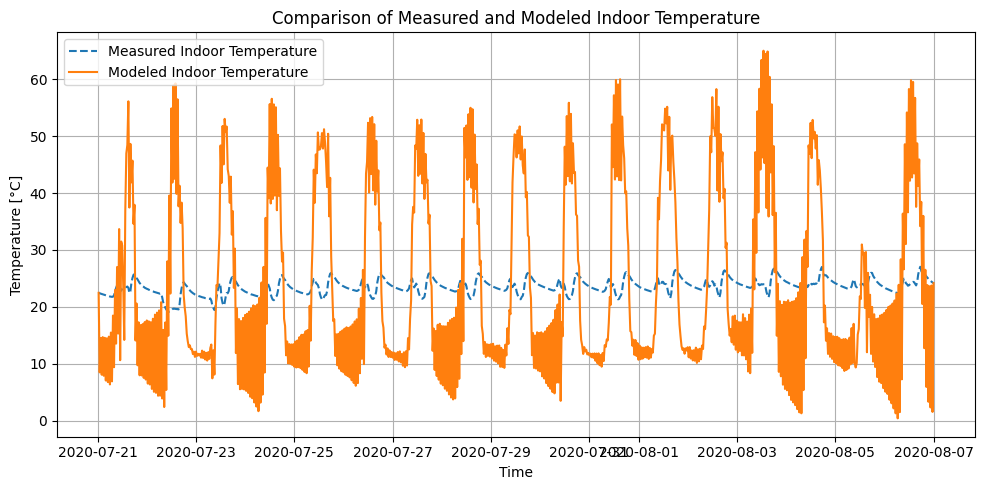

[Trial 1] RMSE = 16.0483, Init: {'R_in_a': 0.3892886123997925, 'C_in': 2713497604.2486415, 'Ain': 14.171582668988837}
 parameters: {'R_in_a': 0.002154535251007903, 'C_in': 411086.729069502, 'Ain': 17.100000170897673, 'fh': 1, 'Objective': 257.5472195054973, 'Solve_time': 5.5461249351501465}


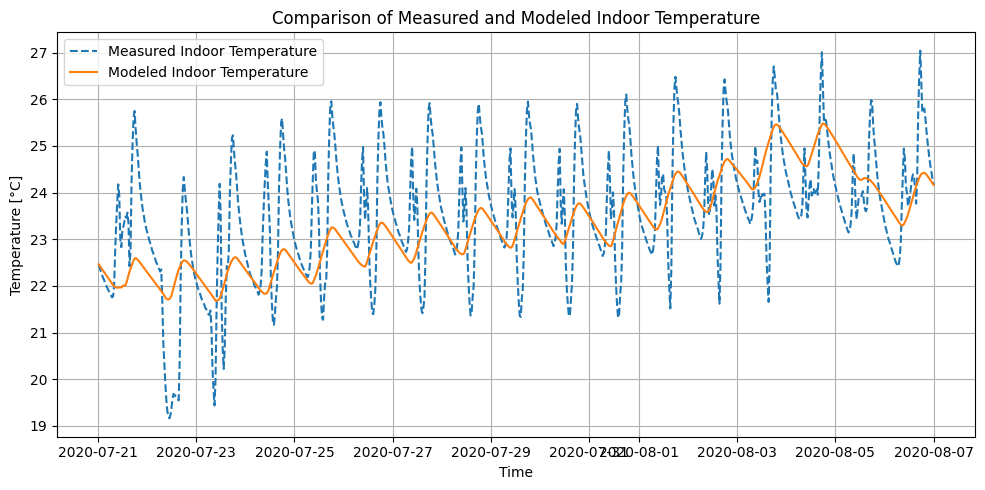

[Trial 2] RMSE = 1.1532, Init: {'R_in_a': 0.3573965733668957, 'C_in': 2809352287.528711, 'Ain': 9.280560325922888}
 parameters: {'R_in_a': 0.0023527941667453307, 'C_in': 266733631.66413787, 'Ain': 16.069804444222484, 'fh': 1, 'Objective': 1.3299118383222444, 'Solve_time': 0.44330716133117676}


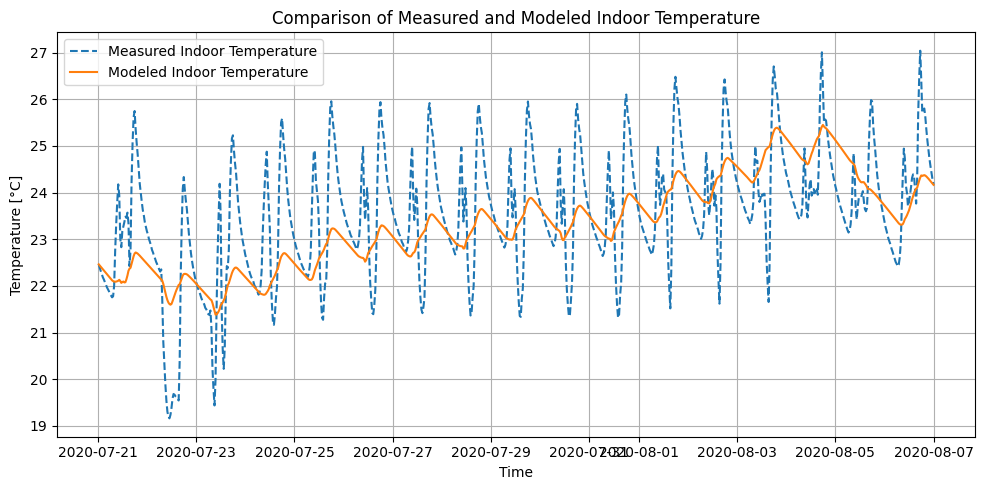

[Trial 3] RMSE = 1.1459, Init: {'R_in_a': 0.14178330074978787, 'C_in': 8021971785.570589, 'Ain': 1.275741456280401}
 parameters: {'R_in_a': 0.012157329134277525, 'C_in': 62855858.68545674, 'Ain': 5.245121335869461, 'fh': 1, 'Objective': 1.3130889595336055, 'Solve_time': 2.926647901535034}


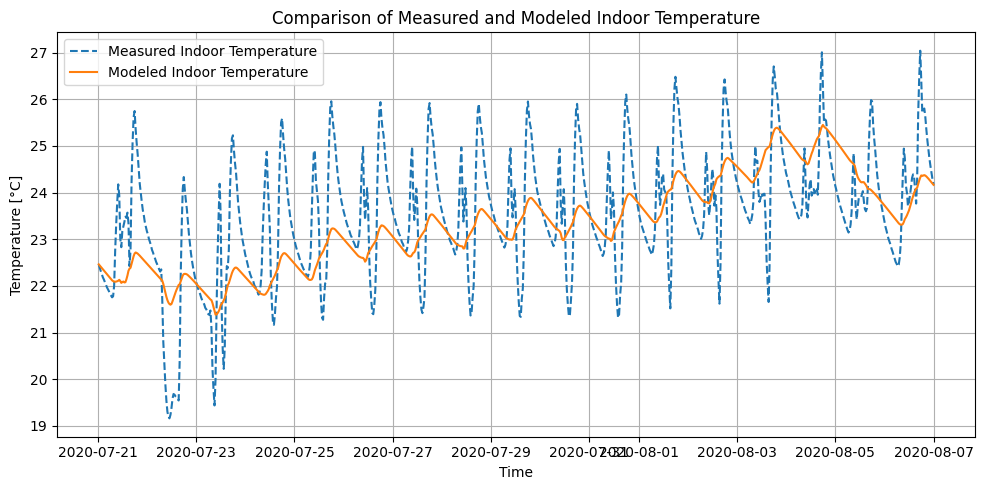

[Trial 4] RMSE = 1.1459, Init: {'R_in_a': 0.9869000496639168, 'C_in': 7722449970.518881, 'Ain': 3.3988394385528133}
 parameters: {'R_in_a': 0.012157329134277828, 'C_in': 62855858.68545806, 'Ain': 5.245121335869416, 'fh': 1, 'Objective': 1.3130889595336044, 'Solve_time': 0.8051130771636963}
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.17\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


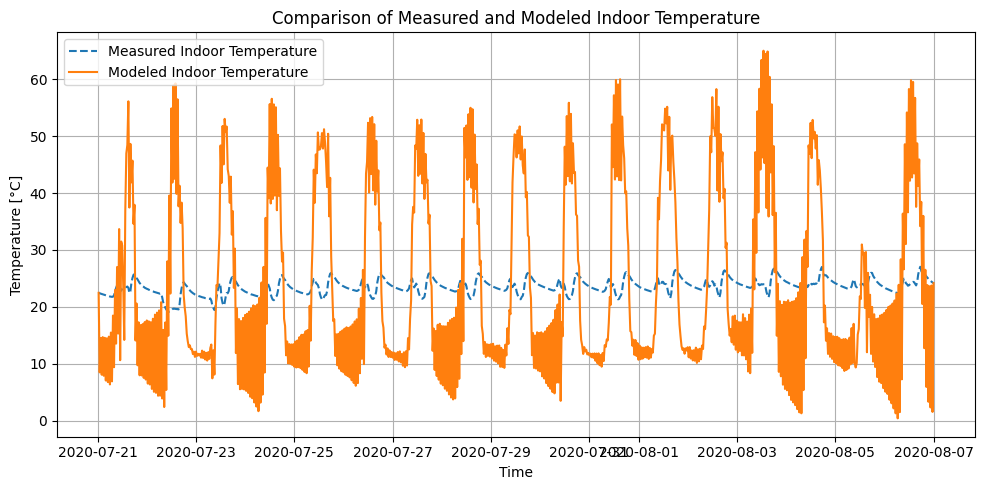

[Trial 5] RMSE = 16.0483, Init: {'R_in_a': 0.006516595006478797, 'C_in': 8154616129.934057, 'Ain': 12.087553722450401}
 parameters: {'R_in_a': 0.002154535253482754, 'C_in': 411086.72856055485, 'Ain': 17.10000017089956, 'fh': 1, 'Objective': 257.547219803831, 'Solve_time': 0.296846866607666}


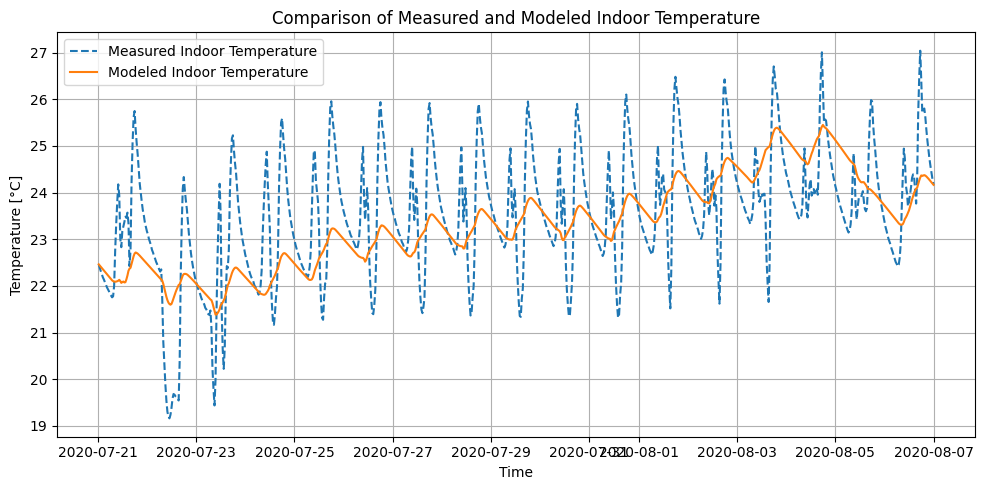

[Trial 6] RMSE = 1.1459, Init: {'R_in_a': 0.7292781608729463, 'C_in': 7712705754.155991, 'Ain': 1.2670895000012108}
 parameters: {'R_in_a': 0.012157329134277596, 'C_in': 62855858.68545722, 'Ain': 5.245121335869461, 'fh': 1, 'Objective': 1.313088959533606, 'Solve_time': 2.954643964767456}


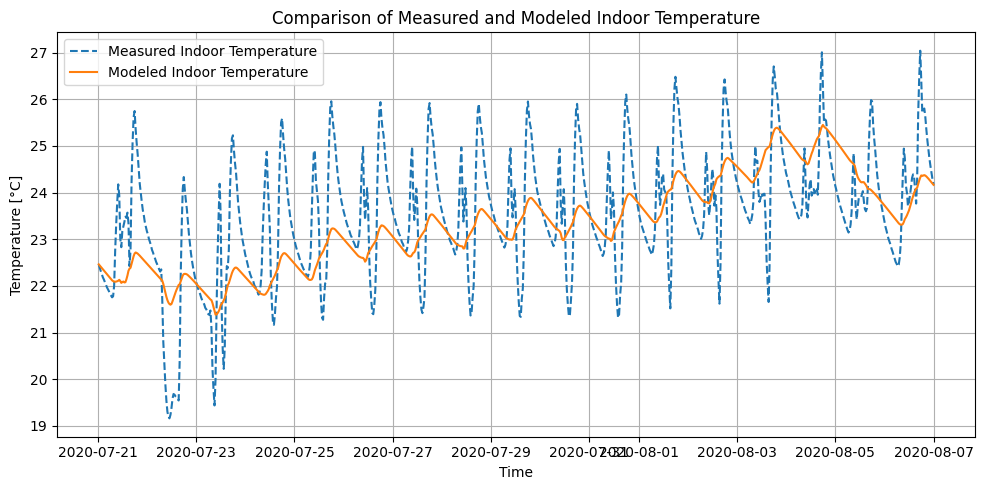

[Trial 7] RMSE = 1.1459, Init: {'R_in_a': 0.35910726281572836, 'C_in': 1158699436.5607018, 'Ain': 14.75920547904677}
 parameters: {'R_in_a': 0.012157329170821508, 'C_in': 62855858.42850637, 'Ain': 5.2451213203512195, 'fh': 1, 'Objective': 1.3130889595195572, 'Solve_time': 0.8489253520965576}


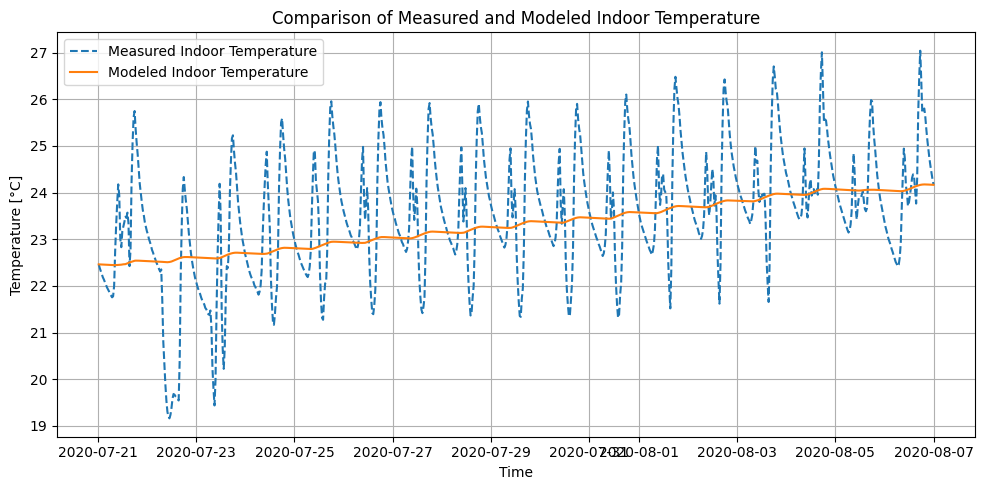

[Trial 8] RMSE = 1.2151, Init: {'R_in_a': 0.6236748287007303, 'C_in': 3308986939.546243, 'Ain': 1.0877842315407178}
 parameters: {'R_in_a': 0.006778188832755301, 'C_in': 2481048085.6043577, 'Ain': 17.0999990940948, 'fh': 1, 'Objective': 1.476584349954892, 'Solve_time': 0.04071497917175293}


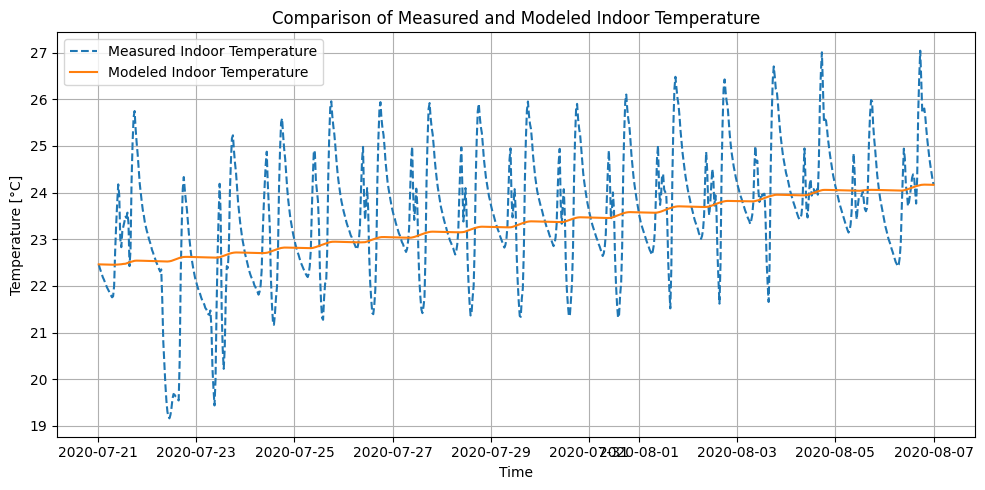

[Trial 9] RMSE = 1.2172, Init: {'R_in_a': 0.31167133939394653, 'C_in': 3251839968.4342504, 'Ain': 12.476536043402554}
 parameters: {'R_in_a': 0.010784685379242955, 'C_in': 2866962802.546195, 'Ain': 17.099998954213806, 'fh': 1, 'Objective': 1.4815855859447367, 'Solve_time': 0.04843282699584961}
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.17\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


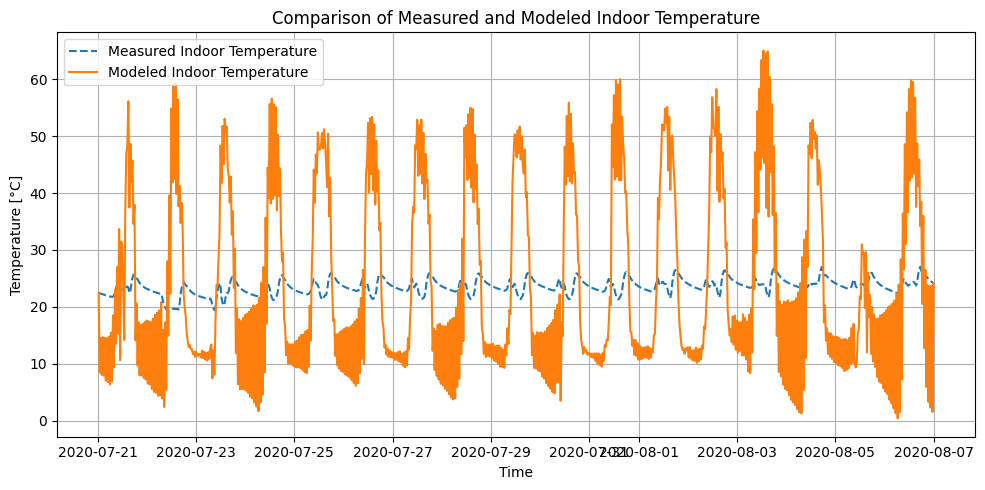

[Trial 10] RMSE = 16.0483, Init: {'R_in_a': 0.6379199138838579, 'C_in': 8872128553.63584, 'Ain': 8.07540300534417}
 parameters: {'R_in_a': 0.002154532386793565, 'C_in': 411087.31808664644, 'Ain': 17.100000170993713, 'fh': 1, 'Objective': 257.54687428473386, 'Solve_time': 21.51384687423706}

=== Best result ===
Best Trial #: 7
Best RMSE: 1.1459
Best initialization: {'R_in_a': 0.35910726281572836, 'C_in': 1158699436.5607018, 'Ain': 14.75920547904677}
Best parameters: {'R_in_a': 0.012157329170821508, 'C_in': 62855858.42850637, 'Ain': 5.2451213203512195, 'fh': 1, 'Objective': 1.3130889595195572, 'Solve_time': 0.8489253520965576}
Solve Time: 35.4246039390564
[Case Study 3] Best Objective achieved in 4 out of 10 trials.
[Case Study 3] Success rate: 40.00%
[Case Study 3] Best Objective was equal to 1.3130889595195572
[Case Study 3] Mean RMSE: 78.22
[Case Study 3] RMSE Std. Dev.: 123.75




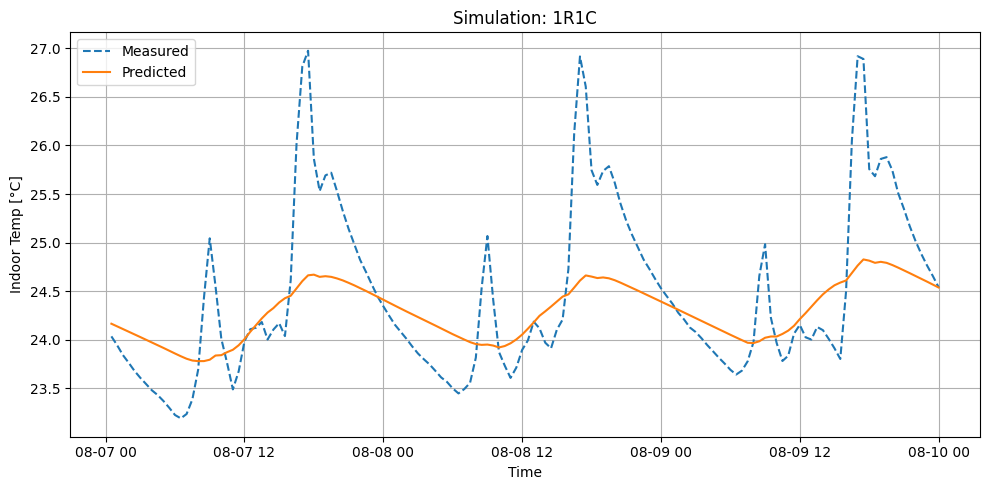

[Case Study 3] Training RMSE: 1.1459009379172167
Validation RMSE: 0.7009




In [8]:
bounds_cs1 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e6, 5e8),
        "Ain": (0.001, 0.3 * cs1_surface_area)
    }
bounds_cs2 = {
        "R_in_a": (0.0001, 1),
        "C_in": (1e6, 1e10),
        "Ain": (0.001, 0.3 * cs2_surface_area)
    }
bounds_cs3 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e4, 1e10),
        "Ain": (0.001, 0.3 * cs3_surface_area)
    }
bounds_cs4 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e4, 1e10),
        "Ain": (0.001, 0.3 * cs4_surface_area)
    }

# model_1r1c_cs1, val_pred_1r1c_cs1, test_pred_1r1c_cs1 = run_case_study(train_df=train_cs1, val_df=val_cs1, test_df=test_cs1, surface_area=cs1_surface_area, model_type="1R1C", label="Case Study 1", bounds=bounds_cs1, trials=5)
# model_1r1c_cs2, val_pred_1r1c_cs2, test_pred_1r1c_cs2= run_case_study(train_df=train_cs2, val_df=val_cs2, test_df=test_cs2, surface_area=cs1_surface_area, model_type="1R1C", label="Case Study 2", bounds=bounds_cs2, trials=5)
# model_1r1c_cs3, val_pred_1r1c_cs3, test_pred_1r1c_cs3 = run_case_study(train_df=train_cs3, val_df=val_cs3, test_df=test_cs3, surface_area=cs1_surface_area, model_type="1R1C", label="Case Study 3", bounds=bounds_cs3, trials=5)
# model_1r1c_cs4, val_pred_1r1c_cs4, test_pred_1r1c_cs4 = run_case_study(train_df=train_cs4, val_df=val_cs4, test_df=test_cs4, surface_area=cs1_surface_area, model_type="1R1C", label="Case Study 4", bounds=bounds_cs4, trials=5)


# model_1r1c_cs1, val_pred_1r1c_cs1, solve_time_1r1c_cs1 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, model_type="1R1C", label="Case Study 1", bounds=bounds_cs1, trials=10)
# model_1r1c_cs2, val_pred_1r1c_cs2, solve_time_1r1c_cs2 = run_case_study(train_df=val_cs2, val_df=test_cs2, surface_area=cs2_surface_area, model_type="1R1C",  label="Case Study 2",bounds=bounds_cs2, trials=10)
model_1r1c_cs3, val_pred_1r1c_cs3, solve_time_1r1c_cs3 = run_case_study(train_df=val_cs3, val_df=test_cs3, surface_area=cs3_surface_area, model_type="1R1C", label="Case Study 3",bounds=bounds_cs3, trials=10)
# model_1r1c_cs4, val_pred_1r1c_cs4, solve_time_1r1c_cs4 = run_case_study(train_df=val_cs4, val_df=test_cs4, surface_area=cs4_surface_area, model_type="1R1C"  , label="Case Study 4",bounds=bounds_cs4, trials=10)


# 2R2C

[Trial 1] RMSE = 0.6707, Init: {'R_e_a': 0.8076327150088984, 'R_in_e': 0.8961952086235697, 'C_in': 159683734.01096007, 'C_e': 55915910.339310706, 'Ain': 6.838826941095709, 'Ae': 12.813806550999063, 'fh': 0.8180147659224931}
 parameters: {'R_in_e': 0.009918978289806752, 'R_e_a': 0.000999990304857885, 'C_in': 153185495.55671698, 'C_e': 292377877.43933624, 'Ain': 11.933243564497667, 'Ae': 29.999991906604972, 'fh': 0.7414669884086788, 'Objective': 0.44982033285898265, 'Solve_time': 0.2231299877166748}
[Trial 2] RMSE = 0.5900, Init: {'R_e_a': 0.8608698526730871, 'R_in_e': 0.007945178400659513, 'C_in': 255862903.9862053, 'C_e': 209288090.57124072, 'Ain': 6.664012206311437, 'Ae': 3.5968411546431502, 'fh': 0.33761517140362796}
 parameters: {'R_in_e': 0.0009999901863829788, 'R_e_a': 0.011331109274425424, 'C_in': 67698439.70983522, 'C_e': 72339027.99406767, 'Ain': 0.9123569964076483, 'Ae': 3.7219427086785517, 'fh': 0.9999999496442581, 'Objective': 0.34812766689946834, 'Solve_time': 0.47578811645

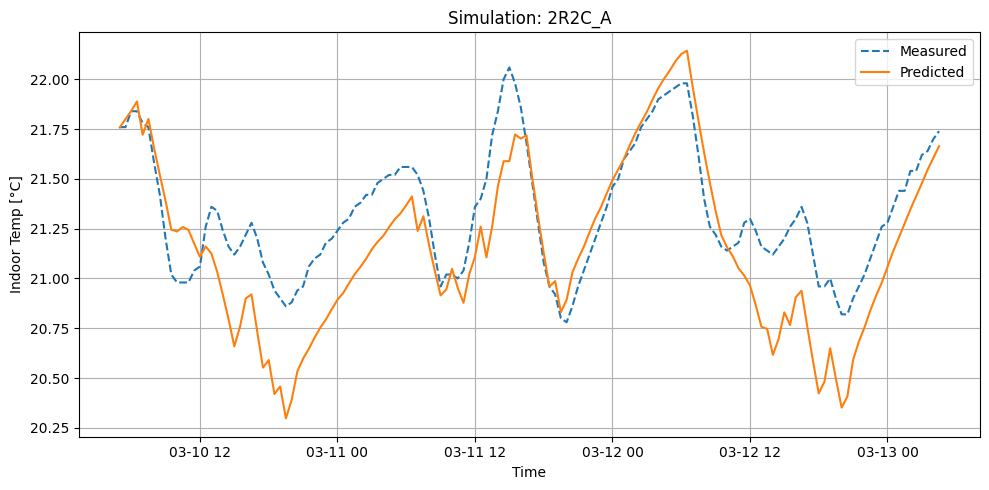

[Case Study 1] Training RMSE: 0.20824768362455132
Validation RMSE: 0.2789


[Trial 1] RMSE = 0.9414, Init: {'R_e_a': 0.09355621642199627, 'R_in_e': 0.8972671500743501, 'C_in': 9004280153.576141, 'C_e': 6331381471.275406, 'Ain': 213.5894293308904, 'Ae': 220.00268279640176, 'fh': 0.7259556788702394}
 parameters: {'R_in_e': 0.0004999900424912024, 'R_e_a': 0.0004999900194985574, 'C_in': 7142227498.517141, 'C_e': 7864209250.298406, 'Ain': 145.428854295944, 'Ae': 0.0010273120215863016, 'fh': 0.3584256462008393, 'Objective': 0.8863102841839944, 'Solve_time': 0.29081010818481445}
[Trial 2] RMSE = 0.9423, Init: {'R_e_a': 0.8971617048226008, 'R_in_e': 0.8871428810529848, 'C_in': 7798975583.030381, 'C_e': 6420674429.896724, 'Ain': 53.00909380691577, 'Ae': 101.82692825089259, 'fh': 0.8985541885270792}
 parameters: {'R_in_e': 0.0004999901136390858, 'R_e_a': 0.0004999900543076841, 'C_in': 7919157622.150626, 'C_e': 6914624564.5612, 'Ain': 143.88510499539996, 'Ae': 0.0010759836331287183, 'fh': 0.38314

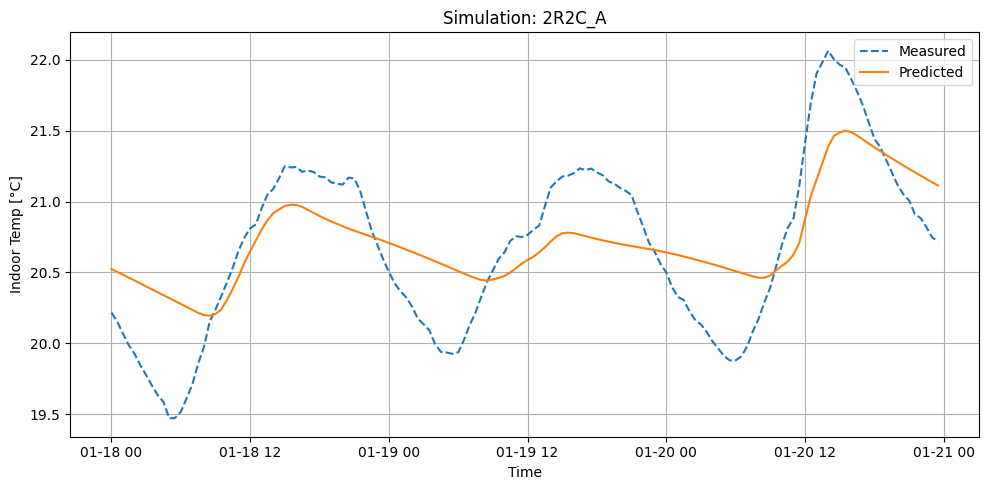

[Case Study 2] Training RMSE: 0.8352197937220127
Validation RMSE: 0.3921


[Trial 1] RMSE = 0.7920, Init: {'R_e_a': 0.6153922194724706, 'R_in_e': 0.990063796254159, 'C_in': 74341587.54207939, 'C_e': 261573177.9200497, 'Ain': 15.003202156896107, 'Ae': 12.667402594979139, 'fh': 0.697015740995268}
 parameters: {'R_in_e': 0.001793654556347712, 'R_e_a': 0.001773415263987856, 'C_in': 5000000.017768014, 'C_e': 451073176.4788936, 'Ain': 3.083776733318746, 'Ae': 17.099927620684063, 'fh': 1.0000000064269061, 'Objective': 0.6272088019641828, 'Solve_time': 0.3889920711517334}
[Trial 2] RMSE = 1.0656, Init: {'R_e_a': 0.7027815999031222, 'R_in_e': 0.3601316600685354, 'C_in': 150327962.91092423, 'C_e': 405633771.96186423, 'Ain': 13.853128935619308, 'Ae': 14.82706957540119, 'fh': 0.9132405525564713}
 parameters: {'R_in_e': 0.000999990179290723, 'R_e_a': 0.0014249396215664277, 'C_in': 147168839.16127855, 'C_e': 394741666.09260345, 'Ain': 15.931928332827512, 'Ae': 0.0010008962331115928, 'fh': 0.99999992

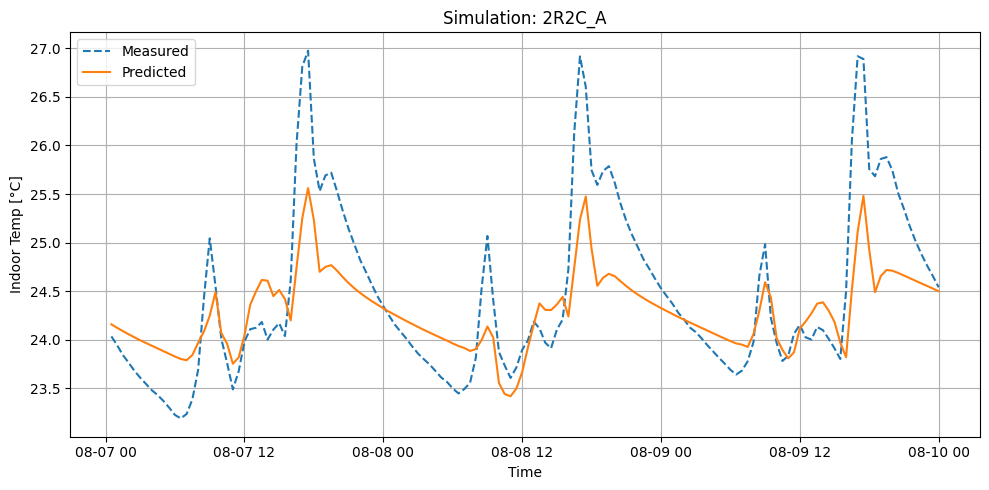

[Case Study 3] Training RMSE: 0.7919651519885095
Validation RMSE: 0.5905


[Trial 1] RMSE = 0.5074, Init: {'R_e_a': 0.3566167059726103, 'R_in_e': 0.7580882643539048, 'C_in': 8182350.826248178, 'C_e': 58920247.612951204, 'Ain': 0.7875991759299501, 'Ae': 0.6974217908520702, 'fh': 0.8554605840110072}
 parameters: {'R_in_e': 0.0023160954690492138, 'R_e_a': 0.006163370509876251, 'C_in': 7456238.738844879, 'C_e': 130086617.02057225, 'Ain': 2.6327827151741174, 'Ae': 4.569676511885752, 'fh': 0.747451889879864, 'Objective': 0.25750412094752245, 'Solve_time': 0.28402090072631836}
[Trial 2] RMSE = 0.8473, Init: {'R_e_a': 0.7039542015206437, 'R_in_e': 0.4746996552582379, 'C_in': 49819246.164849736, 'C_e': 246316321.68329933, 'Ain': 8.09689380857689, 'Ae': 2.962578773591349, 'fh': 0.43385164923797304}
 parameters: {'R_in_e': 0.000999990051739354, 'R_e_a': 0.0009999901016207002, 'C_in': 378653750.231308, 'C_e': 278956515.41040176, 'Ain': 17.099999938675474, 'Ae': 0.28783255260077645, 'fh': 0.5049950

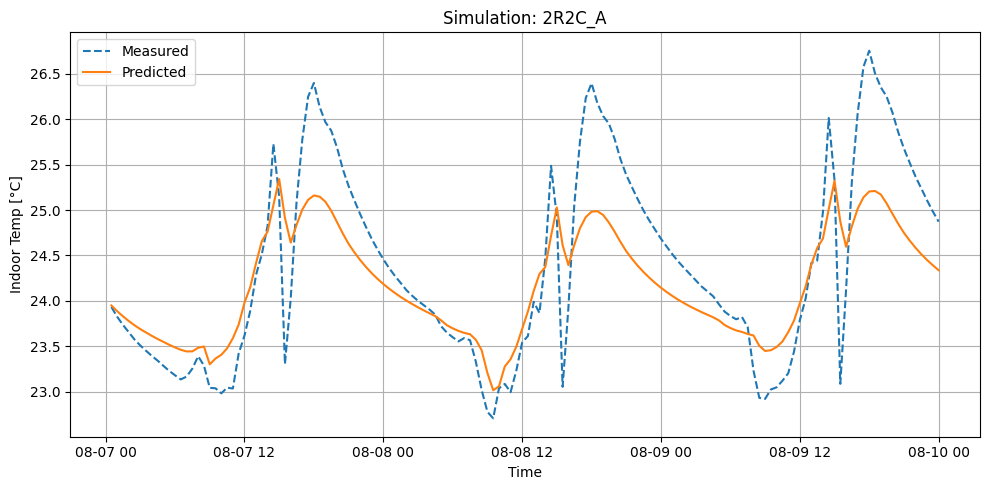

[Case Study 4] Training RMSE: 0.5058781932396439
Validation RMSE: 0.6256




In [5]:
# --- Bounds ---
bounds_cs1 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs1_surface_area),
    "Ae": (0.001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
bounds_cs2 = {
    "R_e_a": (0.0005, 1),
    "R_in_e": (0.0005, 1),
    "C_in": (1e6, 1e10),
    "C_e": (1e6, 1e10),
    "Ain": (0.001, 0.3 * cs2_surface_area),
    "Ae": (0.001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}
bounds_cs3 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (5e6, 5e8),
    "C_e": (5e6, 5e8),
    "Ain": (0.001, 0.3 * cs3_surface_area),
    "Ae": (0.001, 0.3 * cs3_surface_area),
    "fh": (0,1)
}
bounds_cs4 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs4_surface_area),
    "Ae": (0.001, 0.3 * cs4_surface_area),
    "fh": (0,1)
}


# model_2r2c_cs1, val_pred_2r2c_cs1, test_pred_2r2c_cs1 = run_case_study(train_df=train_cs1, val_df=val_cs1, test_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="2R2C_A", bounds=bounds_cs1, trials=5)
# model_2r2c_cs2, val_pred_2r2c_cs2, test_pred_2r2c_cs2 = run_case_study(train_df=train_cs2, val_df=val_cs2, test_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="2R2C_A", bounds=bounds_cs2, trials=5)
# model_2r2c_cs3, val_pred_2r2c_cs3, test_pred_2r2c_cs3 = run_case_study(train_df=train_cs3, val_df=val_cs3, test_df=test_cs3, surface_area=cs3_surface_area, label="Case Study 3",model_type="2R2C_A", bounds=bounds_cs3, trials=5)
# model_2r2c_cs4, val_pred_2r2c_cs4, test_pred_2r2c_cs4 = run_case_study(train_df=train_cs4, val_df=val_cs4, test_df=test_cs4, surface_area=cs4_surface_area, label="Case Study 4",model_type="2R2C_A", bounds=bounds_cs4, trials=5)


model_2r2c_cs1, val_pred_2r2c_cs1, solve_time_2r2c_cs1 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="2R2C_A", bounds=bounds_cs1, trials=10)
model_2r2c_cs2, val_pred_2r2c_cs2, solve_time_2r2c_cs2 = run_case_study(train_df=val_cs2, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="2R2C_A", bounds=bounds_cs2, trials=10)
model_2r2c_cs3, val_pred_2r2c_cs3, solve_time_2r2c_cs3 = run_case_study(train_df=val_cs3, val_df=test_cs3, surface_area=cs3_surface_area, label="Case Study 3",model_type="2R2C_A", bounds=bounds_cs3, trials=10)
model_2r2c_cs4, val_pred_2r2c_cs4, solve_time_2r2c_cs4 = run_case_study(train_df=val_cs4, val_df=test_cs4, surface_area=cs4_surface_area, label="Case Study 4",model_type="2R2C_A", bounds=bounds_cs4, trials=10)


[Trial 1] RMSE = 0.2118, Init: {'R_in_e': 0.10402074496709668, 'R_e_a': 0.902650353772887, 'R_in_a': 0.5057471200754093, 'C_in': 413402275.5877631, 'C_e': 160704750.91427526, 'Ain': 26.865707302563166, 'Ae': 11.676111441857019, 'fh': 0.01083765148029836}
 parameters: {'R_in_e': 0.004630202170027869, 'R_e_a': 0.03446370451234192, 'R_in_a': 0.023420287391484537, 'C_in': 13160527.259009544, 'C_e': 10013348.962171808, 'Ain': 1.1138786734134327, 'Ae': 0.00010022211366422331, 'fh': 0.6222077532578979, 'Objective': 0.04484509183054725, 'Solve_time': 1.4634137153625488}
[Trial 2] RMSE = 0.6313, Init: {'R_in_e': 0.9054765944428443, 'R_e_a': 0.09219539010934742, 'R_in_a': 0.31999432395282446, 'C_in': 475080921.55835164, 'C_e': 475352966.3218405, 'Ain': 17.20317929990977, 'Ae': 18.95515318137276, 'fh': 0.44844552197831977}
 parameters: {'R_in_e': 0.023891537874457504, 'R_e_a': 0.0010550380775111124, 'R_in_a': 0.0088407508946634, 'C_in': 440878180.903652, 'C_e': 469047098.3014314, 'Ain': 29.999998

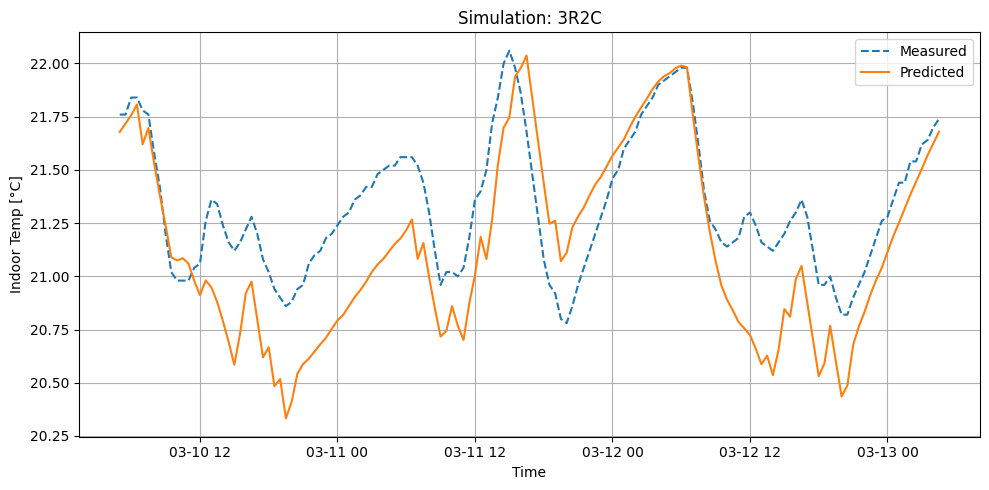

[Case Study 1] Training RMSE: 0.16002134907269924
Validation RMSE: 0.3157


[Trial 1] RMSE = 0.5327, Init: {'R_in_e': 0.6297692394971273, 'R_e_a': 0.6960529402956326, 'R_in_a': 0.45508652370300545, 'C_in': 314151481.9619477, 'C_e': 292572841.64962703, 'Ain': 567.729556493522, 'Ae': 28.631315070480426, 'fh': 0.2809631895922303}
 parameters: {'R_in_e': 0.003093117344101867, 'R_e_a': 0.0016402482254484867, 'R_in_a': 0.0013892641030428155, 'C_in': 499999739.29813826, 'C_e': 499999969.3373964, 'Ain': 149.6849769806658, 'Ae': 0.00013654990437807752, 'fh': 0.1550658791897432, 'Objective': 0.28375929619972384, 'Solve_time': 0.39949679374694824}
[Trial 2] RMSE = 0.5327, Init: {'R_in_e': 0.9504610725924821, 'R_e_a': 0.8903735201070254, 'R_in_a': 0.45620109603292724, 'C_in': 310446166.30296683, 'C_e': 139413210.3075852, 'Ain': 118.51641181385367, 'Ae': 292.13004874234827, 'fh': 0.3533522280260528}
 parameters: {'R_in_e': 0.0030931173441018627, 'R_e_a': 0.0016402482254484821, 'R_in_a': 0.001389264

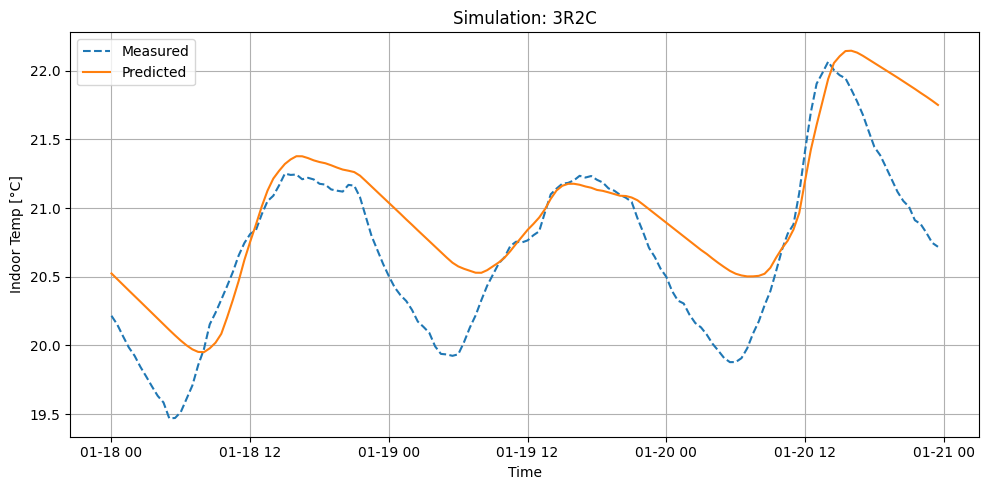

[Case Study 2] Training RMSE: 0.5326906195822636
Validation RMSE: 0.4282


[Trial 1] RMSE = 0.9908, Init: {'R_in_e': 0.7043756883311243, 'R_e_a': 0.21375119734740183, 'R_in_a': 0.137235104111183, 'C_in': 8257788.168273082, 'C_e': 175943191.8444919, 'Ain': 10.08763345344554, 'Ae': 6.707433946800911, 'fh': 0.43747492202372906}
 parameters: {'R_in_e': 0.0009999900025906715, 'R_e_a': 0.9999624328936964, 'R_in_a': 0.0047070807141840094, 'C_in': 1000000.0024629452, 'C_e': 313270860.8788058, 'Ain': 0.00010001807921233251, 'Ae': 10.315512233807413, 'fh': 0.7279937161700556, 'Objective': 0.9816263801800914, 'Solve_time': 1.2895240783691406}
[Trial 2] RMSE = 1.0905, Init: {'R_in_e': 0.9042545357992546, 'R_e_a': 0.3489072115562771, 'R_in_a': 0.514475499670651, 'C_in': 392042853.3578304, 'C_e': 198874848.3783138, 'Ain': 10.637720365226613, 'Ae': 14.746433183198466, 'fh': 0.9495206236576421}
 parameters: {'R_in_e': 0.0020523423868931715, 'R_e_a': 0.9991931384673425, 'R_in_a': 0.002142905767628529, 

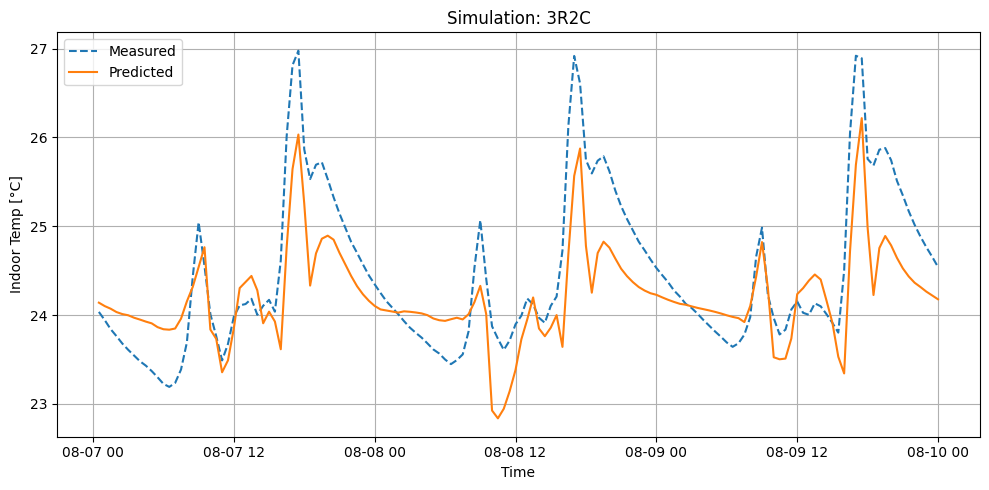

[Case Study 3] Training RMSE: 0.6829497224365184
Validation RMSE: 0.5826


[Trial 1] RMSE = 0.7625, Init: {'R_in_e': 0.021051126579948645, 'R_e_a': 0.3227570864175951, 'R_in_a': 0.2122365589895481, 'C_in': 164421178.73677942, 'C_e': 60761303.77780636, 'Ain': 15.228027447924127, 'Ae': 10.150471596528876, 'fh': 0.6791023191444896}
 parameters: {'R_in_e': 0.0009999900107383712, 'R_e_a': 0.9999943418831475, 'R_in_a': 0.006567660224666345, 'C_in': 1000000.0085238204, 'C_e': 114326855.79268731, 'Ain': 0.29575744210499877, 'Ae': 7.1583049900638045, 'fh': 0.06729357533413816, 'Objective': 0.5814654574700108, 'Solve_time': 0.6715190410614014}
[Trial 2] RMSE = 0.7896, Init: {'R_in_e': 0.789382067368731, 'R_e_a': 0.4989437567301282, 'R_in_a': 0.08783336779933627, 'C_in': 269016164.36745536, 'C_e': 293833717.8924187, 'Ain': 12.747040464604623, 'Ae': 7.381435074572893, 'fh': 0.12758030279556376}
 parameters: {'R_in_e': 0.0009999900264878053, 'R_e_a': 0.01999583320806602, 'R_in_a': 0.000999990041011

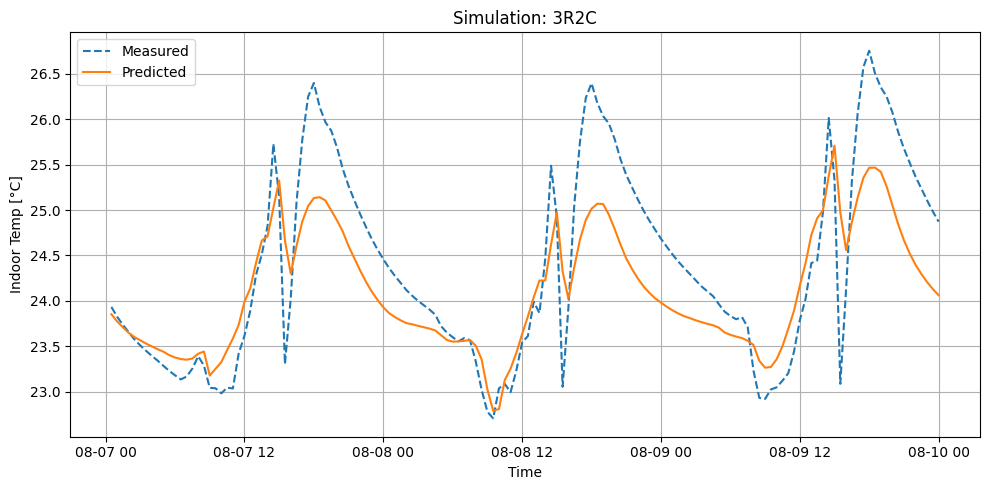

[Case Study 4] Training RMSE: 0.472725690163785
Validation RMSE: 0.6294




In [6]:
# --- Bounds ---
bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}
bounds_cs3 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs3_surface_area),
    "Ae": (0.0001, 0.3 * cs3_surface_area),
    "fh": (0,1)
}
bounds_cs4 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs4_surface_area),
    "Ae": (0.0001, 0.3 * cs4_surface_area),
    "fh": (0,1)
}


# model_3r2c_cs1, val_pred_3r2c_cs1, test_pred_3r2c_cs1 = run_case_study(train_df=train_cs1, val_df=val_cs1, test_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="3R2C", bounds=bounds_cs1, trials=5)
# model_3r2c_cs2, val_pred_3r2c_cs2, test_pred_3r2c_cs2 = run_case_study(train_df=train_cs2, val_df=val_cs1, test_df=test_cs1, surface_area=cs2_surface_area, label="Case Study 2",model_type="3R2C", bounds=bounds_cs2, trials=5)
# model_3r2c_cs3, val_pred_3r2c_cs3, test_pred_3r2c_cs3 = run_case_study(train_df=train_cs3, val_df=val_cs1, test_df=test_cs1, surface_area=cs3_surface_area, label="Case Study 3",model_type="3R2C", bounds=bounds_cs3, trials=5)
# model_3r2c_cs4, val_pred_3r2c_cs4, test_pred_3r2c_cs4 = run_case_study(train_df=train_cs4, val_df=val_cs1, test_df=test_cs1, surface_area=cs4_surface_area, label="Case Study 4",model_type="3R2C", bounds=bounds_cs4, trials=5)


model_3r2c_cs1, val_pred_3r2c_cs1, solve_time_3r2c_cs1 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="3R2C", bounds=bounds_cs1, trials=10)
model_3r2c_cs2, val_pred_3r2c_cs2, solve_time_3r2c_cs2 = run_case_study(train_df=val_cs2, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="3R2C", bounds=bounds_cs2, trials=10)
model_3r2c_cs3, val_pred_3r2c_cs3, solve_time_3r2c_cs3 = run_case_study(train_df=val_cs3, val_df=test_cs3, surface_area=cs3_surface_area, label="Case Study 3",model_type="3R2C", bounds=bounds_cs3, trials=10)
model_3r2c_cs4, val_pred_3r2c_cs4, solve_time_3r2c_cs4 = run_case_study(train_df=val_cs4, val_df=test_cs4, surface_area=cs4_surface_area, label="Case Study 4",model_type="3R2C", bounds=bounds_cs4, trials=10)


[Trial 1] RMSE = 0.2955, Init: {'R_int_in': 0.9384637759073957, 'R_in_e': 0.18287060003332883, 'R_e_a': 0.06836327483204394, 'R_in_a': 0.741638407991479, 'C_int': 287747188.85414004, 'C_in': 421104193.8470261, 'C_e': 70918461.4611932, 'Aint': 23.85803982906552, 'Ain': 6.048899438700331, 'Ae': 4.909761920376848, 'fh_int': 0.16426579793099294, 'fh_in': 0.8145747202313821, 'fh_e': 0.6651972206962001}
 parameters: {'R_int_in': 0.08450403974150966, 'R_in_e': 0.07549306058634588, 'R_e_a': 0.9997917018871542, 'R_in_a': 0.010370397513180259, 'C_int': 499999944.4503022, 'C_in': 40660747.748754494, 'C_e': 358891658.0152442, 'Aint': 0.16812244896253675, 'Ain': 4.472764501539847, 'Ae': 29.981862952904848, 'fh_int': 1.9613423328129795e-08, 'fh_in': 0.9999999606956761, 'fh_e': 1.9690900430987634e-08, 'Objective': 0.08731597948246583, 'Solve_time': 3.138672113418579}
[Trial 2] RMSE = 0.1274, Init: {'R_int_in': 0.5240192939195811, 'R_in_e': 0.3601128231552555, 'R_e_a': 0.8774461397314821, 'R_in_a': 0.

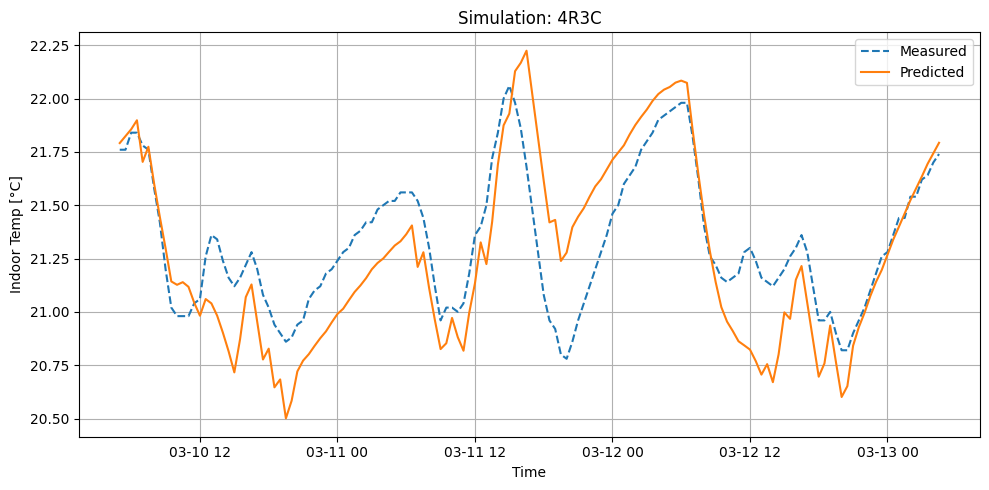

[Case Study 1] Training RMSE: 0.12154874496123426
Validation RMSE: 0.2522


[Trial 1] RMSE = 0.5726, Init: {'R_int_in': 0.06894232443365063, 'R_in_e': 0.7504605494583795, 'R_e_a': 0.2114857819093946, 'R_in_a': 0.8982581808618323, 'C_int': 103523652.67242518, 'C_in': 96315035.06703688, 'C_e': 19430974.322629727, 'Aint': 297.402228212605, 'Ain': 355.849957471335, 'Ae': 41.396536268998055, 'fh_int': 0.7755276166950106, 'fh_in': 0.4532888347480276, 'fh_e': 0.52439026932758}
 parameters: {'R_int_in': 0.9999900220383793, 'R_in_e': 0.002000003228478718, 'R_e_a': 0.003711980690705277, 'R_in_a': 0.0019999900196026018, 'C_int': 494044625.0510486, 'C_in': 491602447.64912987, 'C_e': 489097508.8778046, 'Aint': 0.0003131198038286538, 'Ain': 120.46538802145385, 'Ae': 0.0001321390511393955, 'fh_int': 0.5758977641234951, 'fh_in': 0.08222987638211221, 'fh_e': 0.34187235949439265, 'Objective': 0.3279224198065737, 'Solve_time': 1.8565151691436768}
[Trial 2] RMSE = 0.5726, Init: {'R_int_in': 0.441881221444

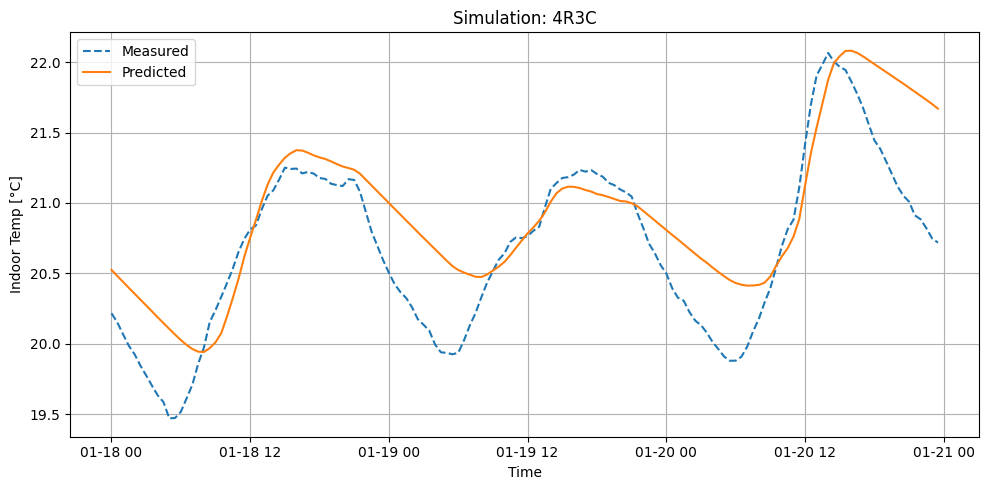

[Case Study 2] Training RMSE: 0.5123253580962532
Validation RMSE: 0.3923


[Trial 1] RMSE = 1.0827, Init: {'R_int_in': 0.3355754030353269, 'R_in_e': 0.7713703793383303, 'R_e_a': 0.10838505662750426, 'R_in_a': 0.07698750617233714, 'C_int': 364420551.5943574, 'C_in': 248351068.52365178, 'C_e': 344575115.33815473, 'Aint': 7.435604007390199, 'Ain': 4.2135501281854015, 'Ae': 14.006667721997045, 'fh_int': 0.7994158789689793, 'fh_in': 0.6946964708544268, 'fh_e': 0.2721451372299627}
 parameters: {'R_int_in': 0.001999990562626614, 'R_in_e': 0.0019999905496739818, 'R_e_a': 0.025686232108401905, 'R_in_a': 0.002589257727667749, 'C_int': 290662853.41653174, 'C_in': 256228815.86503887, 'C_e': 343880583.0245482, 'Aint': 0.00010652796180057417, 'Ain': 17.099999535573467, 'Ae': 0.00010817049422780824, 'fh_int': 4.2229411658757374e-07, 'fh_in': 0.9999991503268878, 'fh_e': 4.2737899558907045e-07, 'Objective': 1.172278672984558, 'Solve_time': 0.9523799419403076}
[Trial 2] RMSE = 1.1064, Init: {'R_int_in':

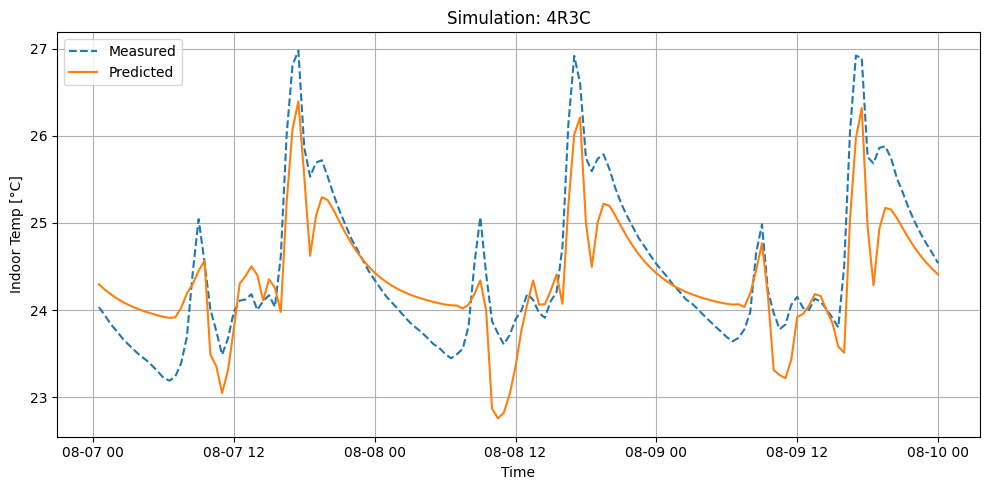

[Case Study 3] Training RMSE: 0.6433501562194792
Validation RMSE: 0.4773


[Trial 1] RMSE = 0.8169, Init: {'R_int_in': 0.8162014587406365, 'R_in_e': 0.22599169069298733, 'R_e_a': 0.22536997959297783, 'R_in_a': 0.5379004740476268, 'C_int': 296958439.49904156, 'C_in': 290547000.4695002, 'C_e': 46833634.49400013, 'Aint': 15.00459300489324, 'Ain': 4.541834168262614, 'Ae': 2.214792202443823, 'fh_int': 0.8887480798689772, 'fh_in': 0.9556514982297534, 'fh_e': 0.8621276172654506}
 parameters: {'R_int_in': 0.0019999900398446615, 'R_in_e': 0.035658656758142566, 'R_e_a': 0.9999954270245214, 'R_in_a': 0.001999990045114183, 'C_int': 384357784.9232973, 'C_in': 283196152.72296387, 'C_e': 51584837.15922506, 'Aint': 0.00010088892257531076, 'Ain': 14.6965262397611, 'Ae': 7.449327011159589, 'fh_int': 1.7138149962490298e-07, 'fh_in': 0.999999713898265, 'fh_e': 1.1472023530664443e-07, 'Objective': 0.6673379128531767, 'Solve_time': 4.803375005722046}
[Trial 2] RMSE = 0.7054, Init: {'R_int_in': 0.80989704257

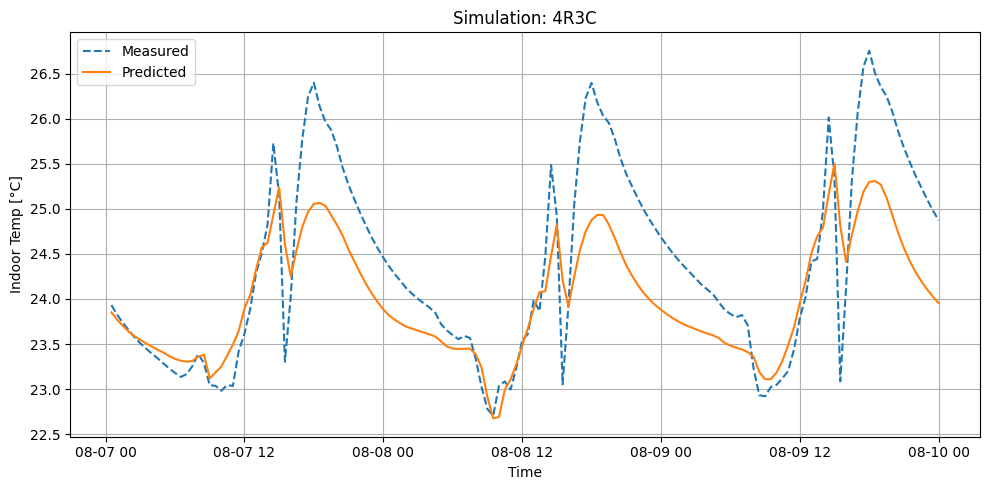

[Case Study 4] Training RMSE: 0.47113834341865224
Validation RMSE: 0.6783




In [7]:
# --- Bounds ---
bounds_cs1 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs1_surface_area),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}
bounds_cs2 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs2_surface_area),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}
bounds_cs3 = {
   "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs3_surface_area),
    "Ain": (0.0001, 0.3 * cs3_surface_area),
    "Ae": (0.0001, 0.3 * cs3_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}
bounds_cs4 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs4_surface_area),
    "Ain": (0.0001, 0.3 * cs4_surface_area),
    "Ae": (0.0001, 0.3 * cs4_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

# model_4r3c_cs1, val_pred_4r3c_cs1, test_pred_4r3c_cs1 = run_case_study(train_df=train_cs1, val_df=val_cs1, test_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="4R3C", bounds=bounds_cs1, trials=5)
# model_4r3c_cs2, val_pred_4r3c_cs2, test_pred_4r3c_cs2 = run_case_study(train_df=train_cs2, val_df=val_cs1, test_df=test_cs1, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=5)
# model_4r3c_cs3, val_pred_4r3c_cs3, test_pred_4r3c_cs3 = run_case_study(train_df=train_cs3, val_df=val_cs1, test_df=test_cs1, surface_area=cs3_surface_area, label="Case Study 3",model_type="4R3C", bounds=bounds_cs3, trials=5)
# model_4r3c_cs4, val_pred_4r3c_cs4, test_pred_4r3c_cs4 = run_case_study(train_df=train_cs4, val_df=val_cs1, test_df=test_cs1, surface_area=cs4_surface_area, label="Case Study 4",model_type="4R3C", bounds=bounds_cs4, trials=5)


model_4r3c_cs1, val_pred_4r3c_cs1, solve_time_4r3c_cs1 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="4R3C", bounds=bounds_cs1, trials=10)
model_4r3c_cs2, val_pred_4r3c_cs2, solve_time_4r3c_cs2 = run_case_study(train_df=val_cs2, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=10)
model_4r3c_cs3, val_pred_4r3c_cs3, solve_time_4r3c_cs3 = run_case_study(train_df=val_cs3, val_df=test_cs3, surface_area=cs3_surface_area, label="Case Study 3",model_type="4R3C", bounds=bounds_cs3, trials=10)
model_4r3c_cs4, val_pred_4r3c_cs4, solve_time_4r3c_cs4 = run_case_study(train_df=val_cs4, val_df=test_cs4, surface_area=cs4_surface_area, label="Case Study 4",model_type="4R3C", bounds=bounds_cs4, trials=10)


RMSE 1R1C Case Study 1: 0.23 °C
RMSE 2R2C Case Study 1: 0.21 °C
RMSE 3R2C Case Study 1: 0.16 °C
RMSE 4R3C Case Study 1: 0.12 °C
RMSE 1R1C Case Study 2: 0.73 °C
RMSE 2R2C Case Study 2: 0.84 °C
RMSE 3R2C Case Study 2: 0.53 °C
RMSE 4R3C Case Study 2: 0.51 °C
RMSE 1R1C Case Study 3: 1.14 °C
RMSE 2R2C Case Study 3: 0.79 °C
RMSE 3R2C Case Study 3: 0.68 °C
RMSE 4R3C Case Study 3: 0.64 °C
RMSE 1R1C Case Study 4: 0.78 °C
RMSE 2R2C Case Study 4: 0.51 °C
RMSE 3R2C Case Study 4: 0.47 °C
RMSE 4R3C Case Study 4: 0.47 °C


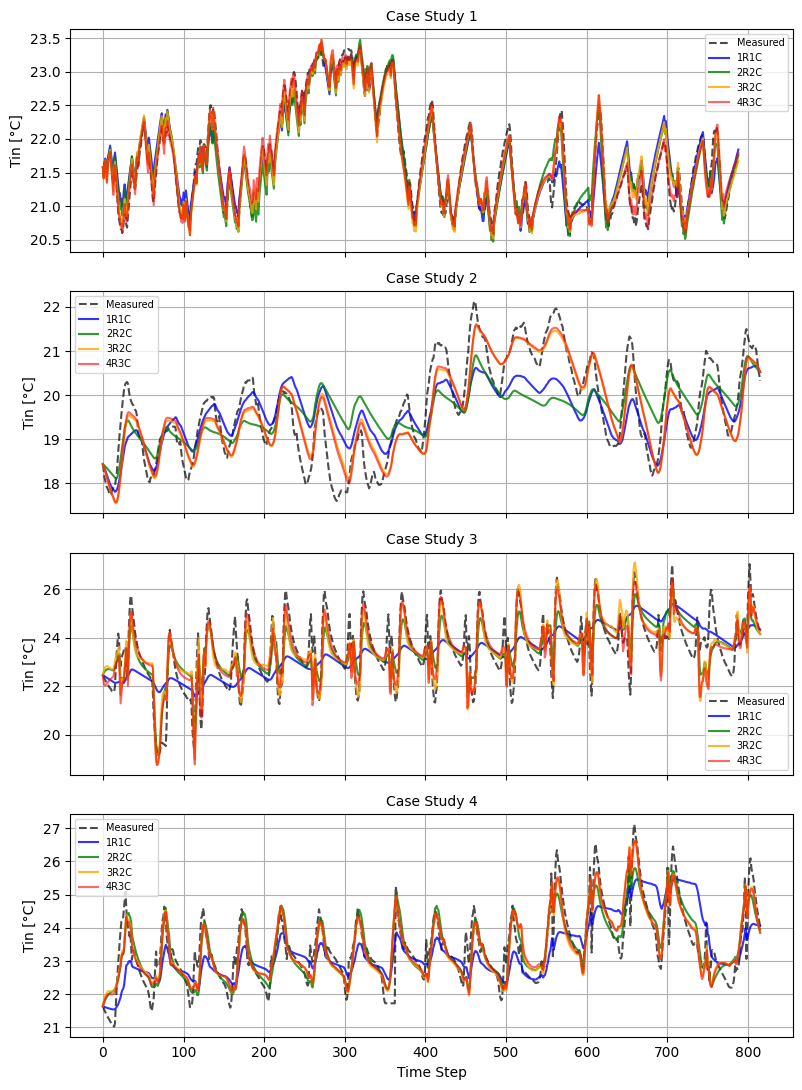

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# === Prepare data ===
datasets = [val_cs1, val_cs2, val_cs3, val_cs4]
labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
colors = ['blue', 'green', 'orange', 'red']
model_sets = [
    [model_1r1c_cs1, model_2r2c_cs1, model_3r2c_cs1, model_4r3c_cs1],
    [model_1r1c_cs2, model_2r2c_cs2, model_3r2c_cs2, model_4r3c_cs2],
    [model_1r1c_cs3, model_2r2c_cs3, model_3r2c_cs3, model_4r3c_cs3],
    [model_1r1c_cs4, model_2r2c_cs4, model_3r2c_cs4, model_4r3c_cs4],
]
model_names = ['1R1C', '2R2C', '3R2C', '4R3C']

# === Create subplots ===
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 11), sharex=True)

for i, (ax, df, models, label) in enumerate(zip(axes, datasets, model_sets, labels)):
    N = len(df)
    x = np.arange(N)
    T_true = df["INDOOR_TEMP"].values[:N]

    ax.plot(x, T_true, linestyle='--', color='black', alpha=0.7, label='Measured')

    for model, color, name in zip(models, colors, model_names):
        if color=='red':
            T_model = np.array([model.T_in[t]() for t in model.T_in.index_set()])
            ax.plot(x, T_model[:N], label=name, color=color, alpha=0.6)
        else:
            T_model = np.array([model.T_in[t]() for t in model.T_in.index_set()])
            ax.plot(x, T_model[:N], label=name, color=color, alpha=0.8)
        print(f"RMSE {name} {label}: {np.sqrt(mean_squared_error(df['INDOOR_TEMP'], T_model[:N])):.2f} °C")
    ax.set_ylabel("Tin [°C]")
    ax.set_title(label, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=7)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()


RMSE 1R1C Case Study 1: 0.30 °C
RMSE 2R2C Case Study 1: 0.28 °C
RMSE 3R2C Case Study 1: 0.32 °C
RMSE 4R3C Case Study 1: 0.25 °C
RMSE 1R1C Case Study 2: 0.39 °C
RMSE 2R2C Case Study 2: 0.39 °C
RMSE 3R2C Case Study 2: 0.43 °C
RMSE 4R3C Case Study 2: 0.39 °C
RMSE 1R1C Case Study 3: 0.70 °C
RMSE 2R2C Case Study 3: 0.59 °C
RMSE 3R2C Case Study 3: 0.58 °C
RMSE 4R3C Case Study 3: 0.48 °C
RMSE 1R1C Case Study 4: 0.89 °C
RMSE 2R2C Case Study 4: 0.63 °C
RMSE 3R2C Case Study 4: 0.63 °C
RMSE 4R3C Case Study 4: 0.68 °C


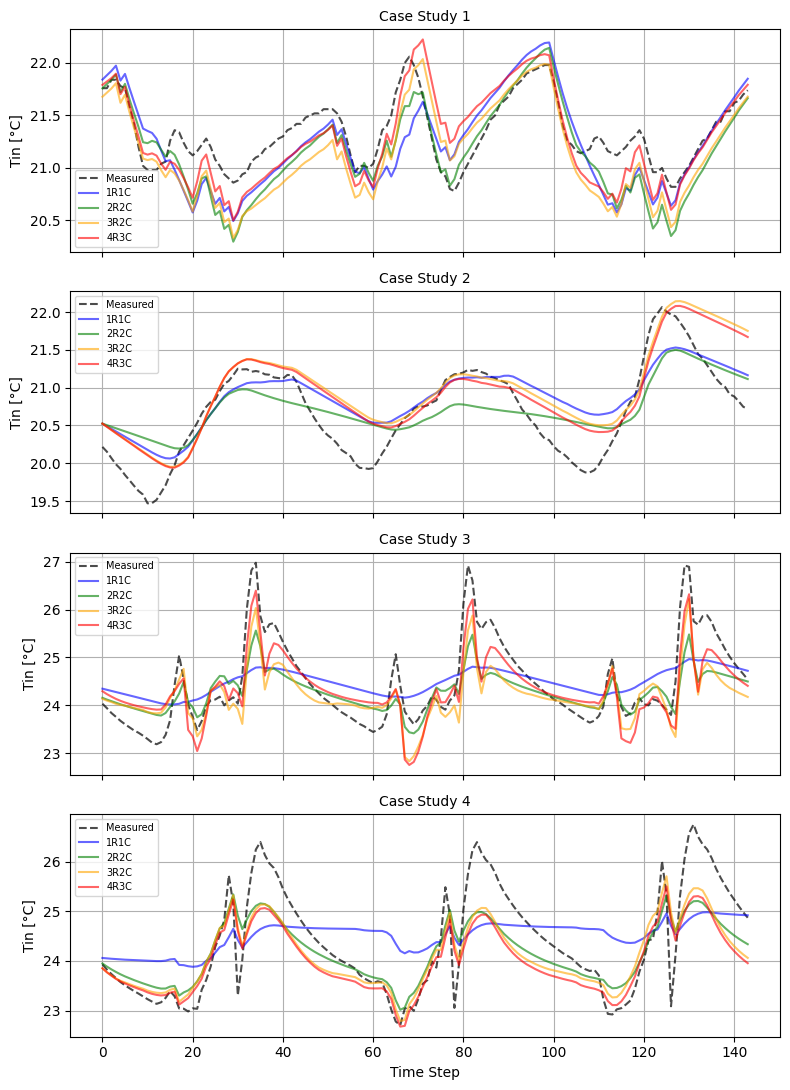

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# === Prepare data ===
datasets = [train_cs1, train_cs2, train_cs3, train_cs4]
labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
colors = ['blue', 'green', 'orange', 'red']
model_sets = [
    [val_pred_1r1c_cs1, val_pred_2r2c_cs1, val_pred_3r2c_cs1, val_pred_4r3c_cs1],
    [val_pred_1r1c_cs2, val_pred_2r2c_cs2, val_pred_3r2c_cs2, val_pred_4r3c_cs2],
    [val_pred_1r1c_cs3, val_pred_2r2c_cs3, val_pred_3r2c_cs3, val_pred_4r3c_cs3],
    [val_pred_1r1c_cs4, val_pred_2r2c_cs4, val_pred_3r2c_cs4, val_pred_4r3c_cs4],
]
model_names = ['1R1C', '2R2C', '3R2C', '4R3C']

# === Create subplots ===
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 11), sharex=True)

for i, (ax, models, label) in enumerate(zip(axes, model_sets, labels)):
    N = len(models[i])
    x = np.arange(N)
    T_true = models[i]["INDOOR_TEMP"]


    ax.plot(x, T_true, linestyle='--', color='black', alpha=0.7, label='Measured')

    for model, color, name in zip(models, colors, model_names):
        T_model = np.array(model['T_in_estimate'])  
        ax.plot(x, T_model[:N], label=name, color=color, alpha=0.6) 
        print (f"RMSE {name} {label}: {np.sqrt(mean_squared_error(model['INDOOR_TEMP'], model['T_in_estimate'])):.2f} °C")
    ax.set_ylabel("Tin [°C]")
    ax.set_title(label, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=7)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()


In [10]:
# import matplotlib.pyplot as plt
# import numpy as np

# # === Prepare data ===
# datasets = [train_cs1, train_cs2, train_cs3, train_cs4]
# labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
# colors = ['blue', 'green', 'orange', 'red']
# model_sets = [
#     [test_pred_1r1c_cs1, test_pred_2r2c_cs1, test_pred_3r2c_cs1, test_pred_4r3c_cs1],
#     [test_pred_1r1c_cs2, test_pred_2r2c_cs2, test_pred_3r2c_cs2, test_pred_4r3c_cs2],
#     [test_pred_1r1c_cs3, test_pred_2r2c_cs3, test_pred_3r2c_cs3, test_pred_4r3c_cs3],
#     [test_pred_1r1c_cs4, test_pred_2r2c_cs4, test_pred_3r2c_cs4, test_pred_4r3c_cs4],
# ]
# model_names = ['1R1C', '2R2C', '3R2C', '4R3C']

# # === Create subplots ===
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 11), sharex=True)

# for i, (ax, models, label) in enumerate(zip(axes, model_sets, labels)):
#     N = len(models[i])
#     x = np.arange(N)
#     T_true = models[i]["INDOOR_TEMP"]


#     ax.plot(x, T_true, linestyle='--', color='black', alpha=0.7, label='Measured')

#     for model, color, name in zip(models, colors, model_names):
#         T_model = np.array(model['T_in_estimate'])  
#         ax.plot(x, T_model[:N], label=name, color=color, alpha=0.6) 

#     ax.set_ylabel("Tin [°C]")
#     ax.set_title(label, fontsize=10)
#     ax.grid(True)
#     ax.legend(fontsize=7)

# axes[-1].set_xlabel("Time Step")
# plt.tight_layout()
# plt.show()


## Computantional Time ##

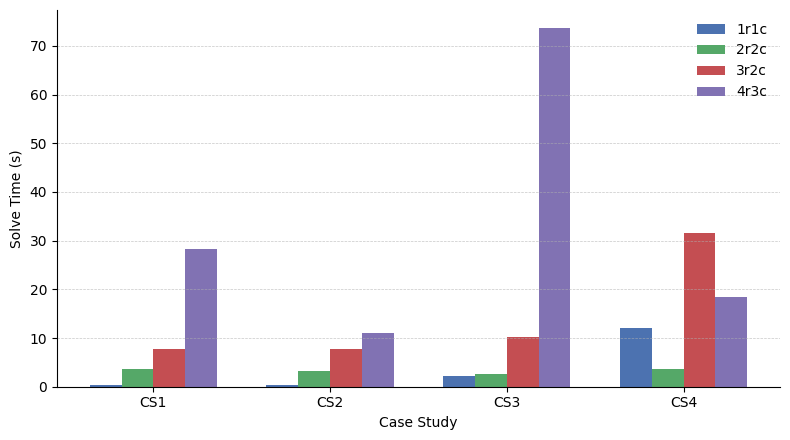

In [22]:
cases = ['CS1', 'CS2', 'CS3', 'CS4']
models = ['1r1c', '2r2c', '3r2c', '4r3c']
solve_times = {
    '1r1c': [solve_time_1r1c_cs1, solve_time_1r1c_cs2, solve_time_1r1c_cs3, solve_time_1r1c_cs4],
    '2r2c': [solve_time_2r2c_cs1, solve_time_2r2c_cs2, solve_time_2r2c_cs3, solve_time_2r2c_cs4],
    '3r2c': [solve_time_3r2c_cs1, solve_time_3r2c_cs2, solve_time_3r2c_cs3, solve_time_3r2c_cs4],
    '4r3c': [solve_time_4r3c_cs1, solve_time_4r3c_cs2, solve_time_4r3c_cs3, solve_time_4r3c_cs4],
}

# Bar plot settings
x = np.arange(len(cases))
width = 0.18
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, model in enumerate(models):
    ax.bar(x + i * width, solve_times[model], width, label=model, color=colors[i])

# Axis formatting
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(cases)
ax.set_ylabel("Solve Time (s)")
ax.set_xlabel("Case Study")
# ax.set_title("Comparison of Solve Time Across Models and Case Studies", fontsize=13, pad=10)

# Style
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()